<a href="https://colab.research.google.com/github/ayush9818/Spine-MRI-classification/blob/main/Spine_detec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install -q keras

In [ ]:
import keras

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt #ggplot
import time
from os import listdir

%matplotlib inline



# DATA PROCESSING




In [ ]:
def crop_spine_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image


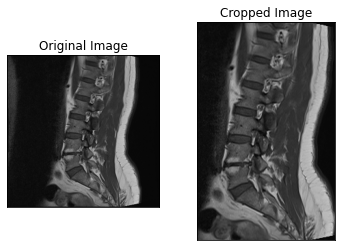

In [ ]:
ex_img = cv2.imread('/content/drive/MyDrive/spine_MRIfull/yes/1t1s00005.jpg')
ex_new_img = crop_spine_contour(ex_img, True)

# DATA LOADER

In [ ]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            
            image = cv2.imread(directory + '/' + filename)
            
            image = crop_spine_contour(image, plot=False)
            
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            
            image = image / 255.
            
            X.append(image)
            
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y
    

In [ ]:
augmented_path = '/content/drive/MyDrive/spine_MRI4k/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (224, 224)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))


Number of examples is: 4041
X shape is: (4041, 224, 224, 3)
y shape is: (4041, 1)


# DATA VISUALIZATION

In [ ]:
  def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "yes" if label == 1 else "no"
        plt.suptitle(f"Degenerative Spine: {label_to_str(label)}")
        plt.show()

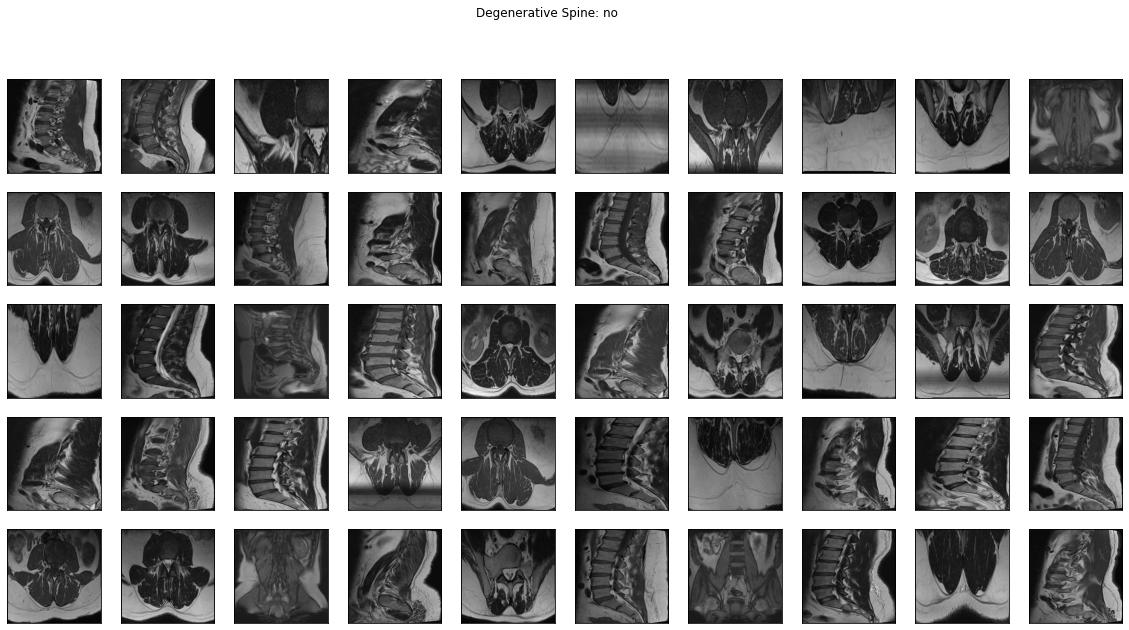

In [ ]:
plot_sample_images(X, y)

# Prepare Train and Test DATA

In [ ]:
def split_data(X, y, test_size=0.2):
       #erase
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    #test size=0.18
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)
#.18
del X,y

NameError: ignored

In [ ]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 2828
number of development examples = 607
number of test examples = 606
X_train shape: (2828, 224, 224, 3)
Y_train shape: (2828, 1)
X_val (dev) shape: (607, 224, 224, 3)
Y_val (dev) shape: (607, 1)
X_test shape: (606, 224, 224, 3)
Y_test shape: (606, 1)


In [ ]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [ ]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    #probability
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

# Model Building and Training

In [ ]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) 
    
    # FLATTEN X 
    X = Flatten()(X)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. 
    model = Model(inputs = X_input, outputs = X, name='DegenerativeSpineDetectionModel')
    
    return model

In [ ]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [ ]:
model = build_model(IMG_SHAPE)

In [ ]:
model.summary()

Model: "DegenerativeSpineDetectionModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 228, 228, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 222, 222, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 222, 222, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 222, 222, 32)      0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 55, 55, 32)        0         
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None,

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=40, validation_data=(X_val, y_val))

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/40
89/89 [==============================] - 5s 54ms/step - loss: 0.7833 - accuracy: 0.5668 - val_loss: 0.6753 - val_accuracy: 0.5865
Epoch 2/40
89/89 [==============================] - 4s 49ms/step - loss: 0.6826 - accuracy: 0.6132 - val_loss: 0.6595 - val_accuracy: 0.6046
Epoch 3/40
89/89 [==============================] - 4s 49ms/step - loss: 0.5907 - accuracy: 0.6807 - val_loss: 0.6618 - val_accuracy: 0.5783
Epoch 4/40
89/89 [==============================] - 4s 49ms/step - loss: 0.5760 - accuracy: 0.6917 - val_loss: 0.5709 - val_accuracy: 0.7117
Epoch 5/40
89/89 [==============================] - 4s 49ms/step - loss: 0.5128 - accuracy: 0.7422 - val_loss: 0.5820 - val_accuracy: 0.6755
Epoch 6/40
89/89 [==============================] - 4s 49ms/step - loss: 0.5081 - accuracy: 0.7436 - val_loss: 0.5448 - val_accuracy: 0.7100
Epoch 7/40
89/89 [==============================] - 4s 49ms/step - loss: 0.4700 - accuracy: 0.7680 - val_loss: 0.5076 - val_accuracy: 0.7199
Epoch 8/40
89

In [ ]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=30, validation_data=(X_val, y_val))

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/30
89/89 [==============================] - 5s 54ms/step - loss: 0.0868 - accuracy: 0.9760 - val_loss: 0.4028 - val_accuracy: 0.8484
Epoch 2/30
89/89 [==============================] - 5s 51ms/step - loss: 0.0763 - accuracy: 0.9823 - val_loss: 0.4703 - val_accuracy: 0.8402
Epoch 3/30
89/89 [==============================] - 5s 51ms/step - loss: 0.0884 - accuracy: 0.9749 - val_loss: 0.4099 - val_accuracy: 0.8435
Epoch 4/30
89/89 [==============================] - 4s 51ms/step - loss: 0.0771 - accuracy: 0.9791 - val_loss: 0.4571 - val_accuracy: 0.8451
Epoch 5/30
89/89 [==============================] - 5s 51ms/step - loss: 0.0706 - accuracy: 0.9834 - val_loss: 0.5351 - val_accuracy: 0.8171
Epoch 6/30
89/89 [==============================] - 5s 51ms/step - loss: 0.0768 - accuracy: 0.9777 - val_loss: 0.4460 - val_accuracy: 0.8451
Epoch 7/30
89/89 [==============================] - 5s 51ms/step - loss: 0.0736 - accuracy: 0.9791 - val_loss: 0.5156 - val_accuracy: 0.8270
Epoch 8/30
89

In [ ]:
history = model.history.history

In [ ]:
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


In [ ]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

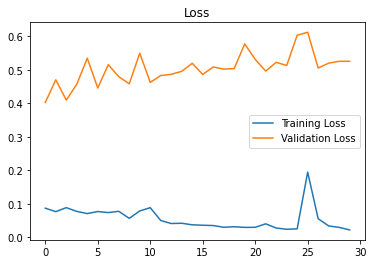

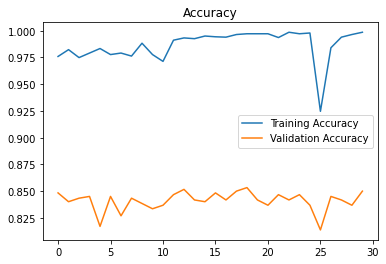

In [ ]:
plot_metrics(history)

In [ ]:
model.save('/content/drive/MyDrive/model_saved')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/model_saved/assets


In [ ]:
from tensorflow.python.keras.models import load_model
model=load_model('/content/drive/MyDrive/model_saved')

# Transfer Learning

In [ ]:
# from tensorflow.keras.applications.resnet50 import ResNet50
# from tensorflow.keras.applications.vgg16 import VGG16
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
# #base_model = ResNet50(weights='imagenet',include_top = False, input_shape = (224,224,3))
# base_model = VGG16(weights='imagenet',include_top = False, input_shape = (224,224,3))
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(512,activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.3)(x)

# x = Dense(256, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.3)(x)


# x = Dense(1, activation='sigmoid')(x)

# model = Model(inputs = base_model.input, outputs = x)

# for layer in base_model.layers:
#   layer.trainable = False



# model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])



In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
base_model = DenseNet121(weights='imagenet',include_top = False, input_shape = (224,224,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512,activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)


x = Dense(1, activation='sigmoid')(x)

model = Model(inputs = base_model.input, outputs = x)

for layer in base_model.layers[:375]:
  layer.trainable = False



model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])


In [ ]:
# for i,layer in enumerate(base_model.layers):
#   print(i)

In [ ]:
#filepath="/content/drive/MyDrive/spine_MRI4k/transfer_model.h5"
# save the model with the best validation (development) accuracy till now
##checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.001)


#model.fit(X_train, y_train, batch_size = 32, epochs = 50, callbacks = [checkpoint,reduce_lr], validation_data = (X_val,y_val))

NameError: ignored

In [ ]:
# ye wala block run krn a or is wale path m model khud save hojaega

filepath="/content/drive/MyDrive/spine_MRI4k/densenet121_model_increased_data.h5"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
#model zada train na ho
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.001)


model.fit(X_train, y_train, batch_size = 32, epochs = 60, callbacks = [checkpoint,reduce_lr], validation_data = (X_val,y_val))

Epoch 1/60
89/89 [==============================] - ETA: 0s - loss: 0.7474 - accuracy: 0.6277
Epoch 00001: val_accuracy improved from -inf to 0.62932, saving model to /content/drive/MyDrive/spine_MRI4k/densenet121_model_increased_data.h5
89/89 [==============================] - 14s 162ms/step - loss: 0.7474 - accuracy: 0.6277 - val_loss: 0.8015 - val_accuracy: 0.6293
Epoch 2/60
88/89 [============================>.] - ETA: 0s - loss: 0.4580 - accuracy: 0.7969
Epoch 00002: val_accuracy improved from 0.62932 to 0.79901, saving model to /content/drive/MyDrive/spine_MRI4k/densenet121_model_increased_data.h5
89/89 [==============================] - 11s 127ms/step - loss: 0.4582 - accuracy: 0.7970 - val_loss: 0.4480 - val_accuracy: 0.7990
Epoch 3/60
88/89 [============================>.] - ETA: 0s - loss: 0.2420 - accuracy: 0.8981
Epoch 00003: val_accuracy did not improve from 0.79901
89/89 [==============================] - 10s 116ms/step - loss: 0.2412 - accuracy: 0.8985 - val_loss: 0.9405

In [ ]:
# Test Accuracy and Validation_accuracy
filepath="/content/drive/MyDrive/spine_MRI4k/densenet121_model_increased_data.h5"
model = load_model(filepath)
loss, test_accuracy = model.evaluate(X_test, y_test)
loss, val_accuracy = model.evaluate(X_val, y_val)

19/19 [==============================] - 2s 86ms/step - loss: 0.2538 - accuracy: 0.9374


In [ ]:
print("Validation Accuracy : {:.2f} %".format(val_accuracy * 100))
print("Test Accuracy : {:.2f} %".format(test_accuracy * 100))

Validation Accuracy : 93.74 %
Test Accuracy : 92.74 %


In [ ]:
# Test Predictions
y_pred = model.predict(X_test)
for i in range(y_pred.shape[0]):
  if y_pred[i] >= 0.5:
    y_pred[i]=1
  else:
    y_pred[i]=0

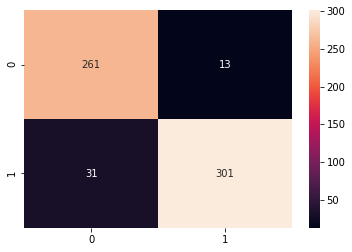

In [ ]:
# Confusion Matrix for Test Data
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm)
sn.heatmap(df_cm, annot=True, fmt='g')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92       274
           1       0.96      0.91      0.93       332

    accuracy                           0.93       606
   macro avg       0.93      0.93      0.93       606
weighted avg       0.93      0.93      0.93       606

